In [1]:
from tensorflow.keras import preprocessing
from tensorflow.keras.applications import mobilenet_v2
from tensorflow import keras
import csv
import os

In [2]:
labels = []

for entry in os.scandir('data'):
    labels.append(entry.name)

In [3]:
# this are the folder names
classes = labels
# plug in the path to your data folder
base_path = 'data/'

In [4]:
# define an image data generator
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=mobilenet_v2.preprocess_input,
    # fill_mode='nearest',
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True, 
    # zoom_range=0.2,
    # shear_range=0.2    
)

In [5]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=443,
        target_size=(224, 224)
)

Found 443 images belonging to 40 classes.


In [6]:
labels = train_data_gen.class_indices
labels = dict((v,k) for k,v in labels.items())

In [9]:
  
with open('label_mapping.csv', 'w') as f:
    for key in labels.keys():
        f.write("%s, %s\n" % (key, labels[key]))

In [8]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((443, 224, 224, 3), (443, 40))

### Select the convolutional base and freeze the weights

In [36]:
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

# freeze it!
base_model.trainable = False

### Add your own dense layers on top

In [190]:
model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(classes), activation='softmax'))
# have a look at the trainable and non-trainable params statistic
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.35_224 (Functi (None, 1280)              410208    
_________________________________________________________________
dense_12 (Dense)             (None, 100)               128100    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 40)                4040      
Total params: 542,348
Trainable params: 132,140
Non-trainable params: 410,208
_________________________________________________________________


### Compile and train!

In [185]:
import matplotlib.pyplot as plt
import numpy

In [191]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
mcp_save = keras.callbacks.ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_categorical_accuracy')


history = model.fit(xtrain, ytrain, 
          epochs=50, 
          verbose=2,
          #batch_size=len(xtrain),
          batch_size=110,        
          callbacks=[callback, mcp_save],
          # use 30% of the data for validation
          validation_split=0.3)



Epoch 1/50
3/3 - 5s - loss: 4.0330 - categorical_accuracy: 0.0387 - val_loss: 3.4307 - val_categorical_accuracy: 0.1278
Epoch 2/50
3/3 - 1s - loss: 3.3126 - categorical_accuracy: 0.1419 - val_loss: 3.1706 - val_categorical_accuracy: 0.2406
Epoch 3/50
3/3 - 1s - loss: 2.9681 - categorical_accuracy: 0.2355 - val_loss: 2.8751 - val_categorical_accuracy: 0.3459
Epoch 4/50
3/3 - 1s - loss: 2.6681 - categorical_accuracy: 0.3677 - val_loss: 2.5640 - val_categorical_accuracy: 0.4962
Epoch 5/50
3/3 - 1s - loss: 2.4417 - categorical_accuracy: 0.4323 - val_loss: 2.2964 - val_categorical_accuracy: 0.5263
Epoch 6/50
3/3 - 1s - loss: 2.1201 - categorical_accuracy: 0.5161 - val_loss: 2.0696 - val_categorical_accuracy: 0.6015
Epoch 7/50
3/3 - 1s - loss: 1.9905 - categorical_accuracy: 0.5000 - val_loss: 1.8442 - val_categorical_accuracy: 0.6391
Epoch 8/50
3/3 - 1s - loss: 1.6861 - categorical_accuracy: 0.6032 - val_loss: 1.6270 - val_categorical_accuracy: 0.7143
Epoch 9/50
3/3 - 1s - loss: 1.4696 - cat

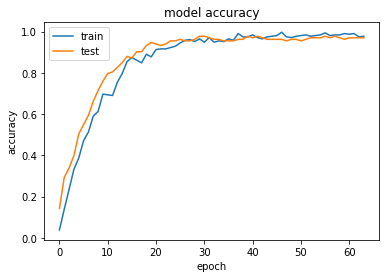

In [39]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save your model for later

In [171]:
test_x = xtrain[-2]

In [172]:
test_x = test_x.reshape(1,224,224,3)

In [173]:
test_x.shape

(1, 224, 224, 3)

In [174]:
test_y = ytrain[-2]

In [175]:
test_y.argmax()

32

In [58]:
result_dict = {}
for count,value in enumerate(classes):
    result_dict[count] = value

In [196]:
model = keras.models.load_model('mdl_wts.hdf5')

In [197]:
result = model.predict(test_x)

In [198]:
sorted_index_array = np.argsort(result[0]) 
sorted_array = result[0][sorted_index_array] 

In [199]:
np.round(result,3)

array([[0.   , 0.002, 0.001, 0.   , 0.   , 0.   , 0.001, 0.   , 0.002,
        0.   , 0.01 , 0.   , 0.002, 0.03 , 0.   , 0.001, 0.   , 0.   ,
        0.001, 0.   , 0.001, 0.012, 0.   , 0.   , 0.001, 0.001, 0.   ,
        0.   , 0.   , 0.003, 0.011, 0.004, 0.909, 0.001, 0.001, 0.   ,
        0.002, 0.   , 0.   , 0.   ]], dtype=float32)

In [200]:
print(sorted_index_array[-3 :])

[21 13 32]


In [201]:
predictions = [labels[k] for k in sorted_index_array[-3 :]]

In [202]:
predictions

['29. Buxus sempervirens', '21. Fraxinus sp', '39. Schinus terebinthifolius']

In [167]:
image = test_x

TypeError: Invalid shape (1, 224, 224, 3) for image data

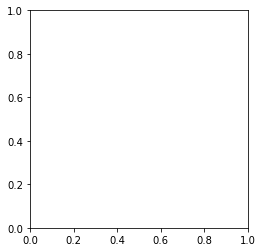

In [168]:
%matplotlib inline 
from matplotlib import pyplot as plt
plt.imshow(image, interpolation='nearest')
plt.show()

In [48]:
from PIL import Image
import numpy as np

w, h = 512, 512
data = np.zeros((h, w, 3), dtype=np.uint8)
data[0:256, 0:256] = [255, 0, 0] # red patch in upper left
img = Image.fromarray(data, 'RGB')
img.save('my.png')
img.show()

In [ ]:
model.save('imageclassifier/models/leaves_model.h5')

---
## Advanced Optional Step: Fine Tuning

This is done after the initial training! Adapt a few of the base layers to the specific learning task by retraining the model. This can improve accuracy, especially if the original learning task of the pre-trained model differs a lot from the actual task.

1. Unfreeze some (or all) of the layers in the convolutional base (starting with the base output layer)
2. Recompile your model and choose a very low learning rate (`1e-5`)
2. Continue training the model but stop early to avoid overfitting

## How to continue!

- Load the trained model into the `capture.py`
- Write a fuction `predict_frame(frame)` that uses the trained model to predict the object in the current frame. It should return a dictionary of class probabilities and names.
    - make sure that the input image to the model is of size (224, 224)
    - apply the same pre-processing using `preprocess_input` from keras
- Modify the script such that it makes a prediction once you press the `p` key
- Write the prediction as a log message to the terminal

### Advanced

- Display the result of the prediction on the current webcam frame
- Make an automatic prediction every second (Hint: the `while` loop has a speed of approx. 30 frames per second)